# Случайность в вероятности и на практике

О подходах к понятию случайности: 

Н.К. Верещагин, В.А. Успенский, А. Шень. Колмогоровская сложность и алгоритмическая случайность. 
https://www.mccme.ru/free-books/shen/kolmbook.pdf

А.Н. Ширяев. Случайность в вероятности (доклад на семинаре кафедры теории веротяностей). http://www.mathnet.ru:8080/PresentFiles/21897/bsk_2018_10_17_shiryaev_an_randomness_in_probability_slides.pdf

## Генераторы случайных чисел

Что происходит при вызове, напрмер, ```np.random.rand()```?

Как устроен источник случайной последовательности?

![img](https://cdn.ablebits.com/_img-blog/random-generator/random-generator.png)

Рассмотрим простой и популрный алгоритм - Linear congruential generator (LCG). При вызове функции ```rand()``` в C/C++ происзодит обращение именно к LCG.

Linear congruential generator производит последовательность:
$$ z_{i+1} = (az_i + c) \mod m $$

Число $z_0$ называется *seed* и обеспечивает воспроизводимость последовательности “случайных” чисел.

Напишем функцию, которая реализует LCG:

In [1]:
def rng(m=2**32, a=1103515245, c=12345):
    rng.current = (a * rng.current + c) % m
    return rng.current / m

# setting the seed
rng.current = 1

Выведем несколько первых элементов последовательности:

In [ ]:
[rng() for i in range(10)]

[0.25693503906950355,
 0.5878706516232342,
 0.15432575810700655,
 0.767266943352297,
 0.9738139626570046,
 0.5858681506942958,
 0.8511155843734741,
 0.6132153405342251,
 0.7473867232911289,
 0.06236015981994569]

Выбор параметров $m$, $a$ и $c$ существенно влияет на качество последовательности. Если параметры выбрать наобум, это может привести к неожиданным последствиям:

In [38]:
def rng(m=97, a=5, c=0):
    rng.current = (a * rng.current + c) % m
    return rng.current / m
rng.current = 7

random = [rng() for i in range(1000)]
print("This sequence looks as random:")
random[:10]

This sequence looks as random:


[0.36082474226804123,
 0.8041237113402062,
 0.020618556701030927,
 0.10309278350515463,
 0.5154639175257731,
 0.5773195876288659,
 0.8865979381443299,
 0.4329896907216495,
 0.16494845360824742,
 0.8247422680412371]

Гистограмма распределения похожа на равномерное:

AttributeError: 'Rectangle' object has no property 'normed'

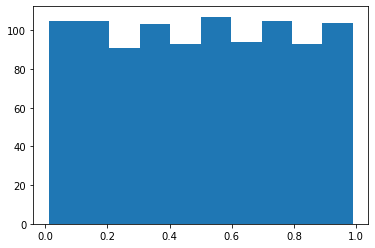

In [39]:
import matplotlib.pyplot as plt
plt.hist(random, normed=True)
plt.show()

Однако, спектральный тест показывает, что точки располагаются на гиперплоскостях, что плохо согласуется с предствалением о случайности:

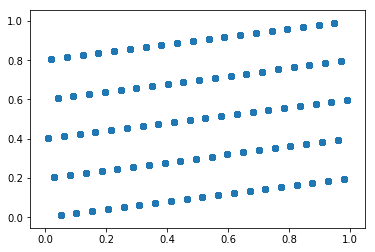

In [ ]:
plt.scatter(random[1:], random[:-1])
plt.show()

Более аккуратный выбор параметров приводит с более "случайному" распределению:

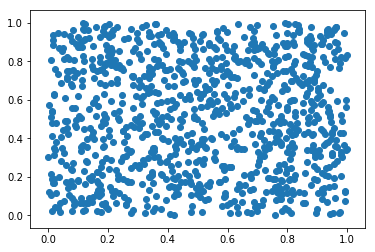

In [ ]:
def rng(m=2**32, a=1103515245, c=12345):
    rng.current = (a * rng.current + c) % m
    return rng.current / m
rng.current = 1

random = [rng() for i in range(1000)]
plt.scatter(random[1:], random[:-1])
plt.show()

Существует набор тестов для проверки "случайности". Например, тесты [Diehard tests](https://en.wikipedia.org/wiki/Diehard_tests).

Больше методов генерации собрано [здесь](https://en.wikipedia.org/wiki/List_of_random_number_generators).

Сюжет про динамические системы и переход к хаосу https://www.youtube.com/watch?v=ovJcsL7vyrk&feature=youtu.be

## Генерация выборки из заданного распределения

Допустим, у нас есть генератор случайных числе из отрезка [0, 1]. Как получить выборку из нового распределения $F$?



### Задача
Смоделировать выборку объема 1000 из дискретного распределения на множестве цифр 0, 1, 2, ..., 9 с весами 0.12, 0.3, 0.167, 0.24, 0.31, 0.54, 0.111, 0.02, 0.001, 0.2. По выборке построить гистограмму. Оптимизируйте алгоритм, упорядочив веса. Сравните время генерации выборки с неупорядоченными и упорядоченными весами.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time

unsorted time:  0.0009796619415283203


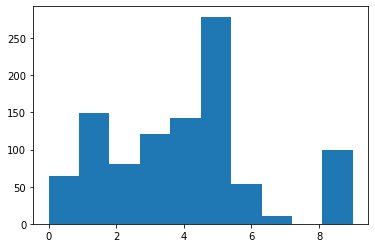

In [83]:
def get_rand(arr, n):
    r = np.random.rand(n)
    return np.searchsorted(arr, r)


arr = np.array([0.12, 0.3, 0.167, 0.24, 0.31, 0.54, 0.111, 0.02, 0.001, 0.2])
arr /= arr.sum()
arr = arr.cumsum()
s = time.time()
r = get_rand(arr, 1000)
e = time.time()
plt.hist(r)
print("unsorted time: ", e - s)

sorted time:  0.0010008811950683594


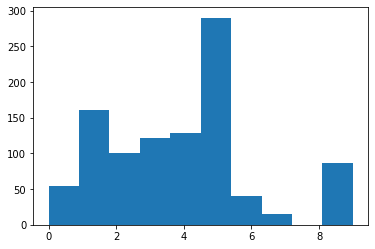

In [87]:
def get_rand(arr, n):
    r = np.random.rand(n)
    return np.searchsorted(arr, r)


arr = np.array([0.12, 0.3, 0.167, 0.24, 0.31, 0.54, 0.111, 0.02, 0.001, 0.2])
arr_sorted = np.sort(arr)
arr_sorted /= arr_sorted.sum()
arr_sorted = np.cumsum(arr_sorted)
s = time.time()
r = np.argsort(arr)[get_rand(arr_sorted, 1000)]
e = time.time()
plt.hist(r)
print("sorted time: ", e - s)

### Inverse transform method

В следующем предложении заключается идея метода *inverse transform*:

Если $\xi$ имеет равномерное распределение в $[0,1]$, тогда $F^{-1}(\xi)$ распределена по закону $F$. (Для каких $F$ это верно?)

### Задача
Смоделируйте выборку размера 1000 из распределения $Exp(\lambda)$. Постройте выборочную гистограмму и точный график плотности распределения.

In [49]:
def rng(l):
    y = np.random.rand()
    return -1 / l * np.log(1 - y)
def f(l, x):
    return l * np.exp(-l * x)

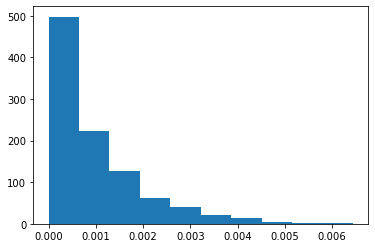

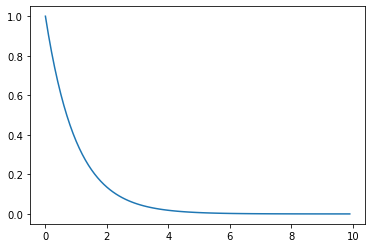

In [51]:
x = [rng(1) for i in range(1000)]
plt.hist(x )
plt.show()
a = np.arange(0, 10, 0.1)
y = [f(1, x) for x in a]
plt.plot(a, y)

### Rejection sampling (Accept-reject method)

Идея метода: сэмплить из распределения, из которого умеем, а затем отбирать точки, которые следуют нужному распределению. Картинка иллюстрирует идею метода:
<img src=https://colcarroll.github.io/hamiltonian_monte_carlo_talk/images/bayes_talk.015.png style="width: 50%;"/>
 

### Задача
Обоснуйте, что метод accept-reject действительно производит выборку из нужного распределения. Смоделируйте 1000 точек из усеченного распределения Коши, приведенного ниже, используя генератор равномерного распределения. Нарисуйте график полученной выборочной гистограммы и сравните его с графиком точной функции плотности.

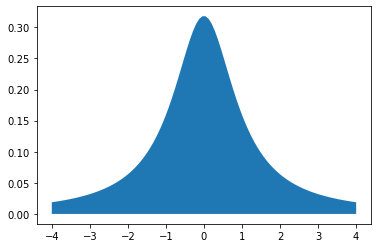

In [58]:
from scipy import stats
import numpy as np
dist = stats.cauchy()
x = np.linspace(-4, 4, 100)
plt.fill_between(x, 0, dist.pdf(x)) #needs to be normalized!
plt.show()

In [59]:
def rng():
    while(1):
        x = (np.random.rand() - 0.5) * 4
        y = np.random.rand() * 0.4
        if dist.pdf(x) > y: return x

(array([ 44.,  62.,  86., 133., 157., 186., 136.,  90.,  67.,  39.]),
 array([-1.99770721, -1.59885989, -1.20001257, -0.80116526, -0.40231794,
        -0.00347062,  0.3953767 ,  0.79422401,  1.19307133,  1.59191865,
         1.99076597]),
 <a list of 10 Patch objects>)

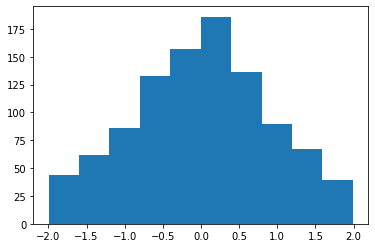

In [62]:
y = [rng() for i in range(1000)]
plt.hist(y)

##  Coordinate transformation method

Метод аccept-reject в ряде случаев может оказываться неэффективным и требовать слишком много пробных точек. Альтернатива -  попробовать найти преобразование координат, которое переводит простую область (из которой легко сэмплить, например, едининчный квадрат) в требуемую, но при этом сохраняет соотношение площадей.

### Задача
Смоделировать выборку из 500 точек равномерно распределенных внутри данного треугольника без использования метода отбора. 

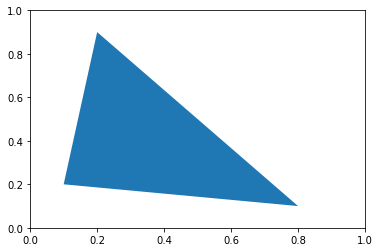

In [88]:
import matplotlib
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import math

polygon = Polygon(0.1 * np.array([[1, 2], [2, 9], [8, 1]]), True)
plt.gca().add_collection(PatchCollection([polygon]))
plt.show()

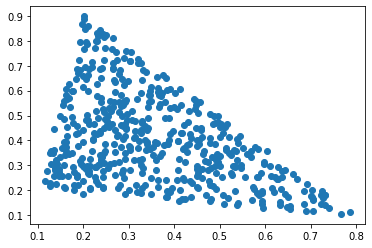

In [123]:
def hypot(v):
    return math.sqrt(v[0] ** 2 + v[1] ** 2)

def get_rand(A, B, C, n):
    x = np.random.rand(n)
    y = np.random.rand(n)
    t = y > 1 - x
    y[t], x[t] = 1 - y[t], 1 - x[t]
    res_x = x
    res_y = y
    x *= hypot(B - A)
    y *= hypot(C - A)
    phi = math.acos((C - A)[0] / hypot(C - A)) - math.pi / 2
    
    res_x = x * math.cos(phi) - y * math.sin(phi) + A[0]
    res_y = x * math.sin(phi) + y * math.cos(phi) + A[1]
    return [res_x, res_y]

A = 0.1 * np.array([1, 2])
B = 0.1 * np.array([8, 1])
C = 0.1 * np.array([2, 9])
rn = get_rand(A, B, C, 500)
plt.scatter(rn[0], rn[1])

### Задача
Смоделировать выборку из 500 точек внутри данного круга без использования метода отбора.

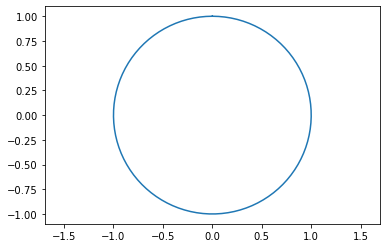

In [144]:
from matplotlib.patches import Circle
t = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.sin(t), np.cos(t))
plt.axis('equal')
plt.show()

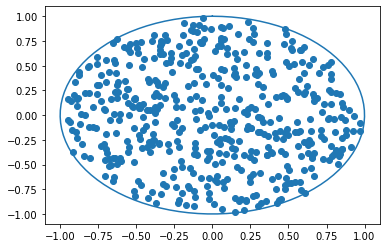

In [143]:
def get_rand(n):
    r = np.random.rand(n)
    phi = np.random.rand(n) * 2 * math.pi
    return [r ** 0.5 * np.cos(phi), r ** 0.5 * np.sin(phi)]

rand = get_rand(500)
plt.scatter(rand[0], rand[1])
t = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.sin(t), np.cos(t))
plt.show()

### Задача
Напишите функцию, которая моделирует случайное симметричное блуждание на двумерной решетке длины n c началом и концом в точке (0, 0). Приведите графики выборочных траекторий для n=100.

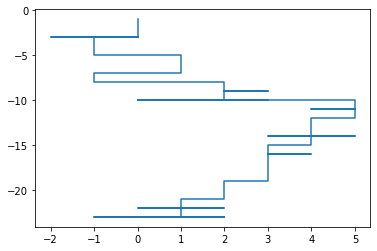

In [164]:
r = np.random.rand(100)
x = np.repeat(0, 100); y = np.repeat(0, 100)
#print(x[r > 0.25 and r < 0.5])
x[r < 0.25], x[np.logical_and(r > 0.25, r < 0.5)] = 1, -1
y[np.logical_and(r > 0.5, r < 0.25)], y[r > 0.75] = 1, -1
np.insert(x, 0, 0); np.insert(y, 0, 0)
x = np.cumsum(x)
y = np.cumsum(y)
plt.plot(x, y)

## Random normal generator

### Задача
Докажите, что приведенный ниже алгоритм (Box-Muller algorithm) формирует выборку из независимых N(0,1) случаных величин. Модифицируйте метод, чтобы исключить вызовы тригонометрических функций ```np.sin``` и ```np.cos```. С помощью модифицированного метода смоделируйте выборку объема 1000 из двумерного гауссовского распределения со средним (3, 6) и ковариационной матрицей ((2, 1), (1, 4)). Постройте 2D гистограмму полученного распределения.

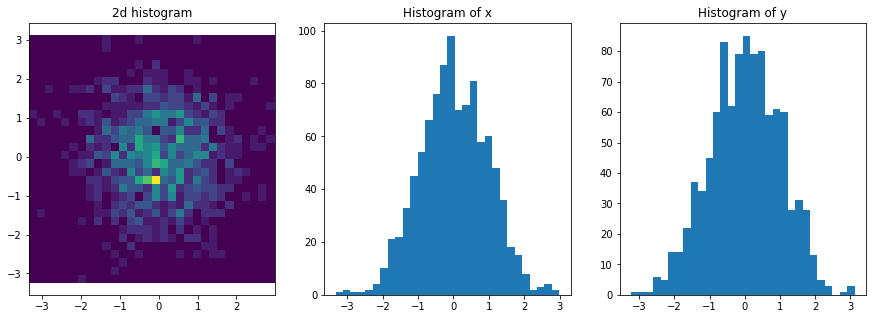

In [39]:
n = 1000
u1, u2 = np.random.rand(2, n)
r = np.sqrt(-2 * np.log(u1))
theta = 2 * np.pi * u2
x = r * np.cos(theta)
y = r * np.sin(theta)
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].hist2d(x, y, bins=30)
ax[0].axis('equal')
ax[1].hist(x, bins=30)
ax[2].hist(y, bins=30)
ax[0].set_title("2d histogram")
ax[1].set_title("Histogram of x")
ax[2].set_title("Histogram of y")
plt.show()

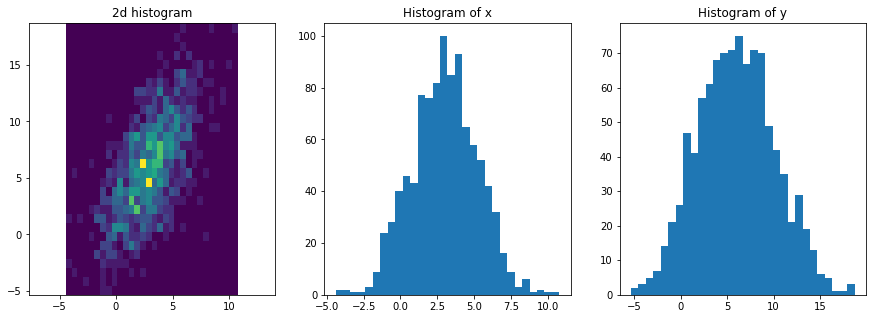

In [46]:
import math
def get_rand(mu, cov):
    x = 0; y = 0; s = 0
    while(1):
        x, y = (np.random.rand(2, 1) - 0.5) * 2
        s = x ** 2 + y ** 2
        if s <= 1: break
    x = x * math.sqrt(-2 * np.log(s) / s)
    y = y * math.sqrt(-2 * np.log(s) / s)
    return mu + np.array([x, y]).T.dot(cov)

n = 1000
mu = np.array([3, 6]); cov = np.array([[2, 1], [1, 4]])
r = np.array([get_rand(mu, cov) for i in range(n)])

#print(r[:, 0, 0])
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].hist2d(r[:, 0, 0], r[:, 0, 1], bins=30)
ax[0].axis('equal')
ax[1].hist(r[:, 0, 0], bins=30)
ax[2].hist(r[:, 0, 1], bins=30)
ax[0].set_title("2d histogram")
ax[1].set_title("Histogram of x")
ax[2].set_title("Histogram of y")
plt.show()

### Задача
Перейдите от вектора из независимых стандартных нормальных величин к гауссовскому вектору с нулевым средним и заданной ниже ковариационно матрицей. Обоснуйте теоретически и численно, что полученный вектор обладает требуемой ковариационной матрицей.


In [ ]:
B = np.array([[ 2.,  0.,  0.,  0., -1.,  0.,  0.,  0., -1.],
              [ 0.,  4.,  0., -1.,  0.,  0.,  0.,  0.,  0.],
              [ 0.,  0.,  4.,  0.,  0.,  0., -1.,  0.,  0.],
              [ 0., -1.,  0.,  4.,  0.,  0.,  0.,  0.,  0.],
              [-1.,  0.,  0.,  0.,  2.,  0.,  0.,  0., -1.],
              [ 0.,  0.,  0.,  0.,  0.,  4.,  0., -1.,  0.],
              [ 0.,  0., -1.,  0.,  0.,  0.,  4.,  0.,  0.],
              [ 0.,  0.,  0.,  0.,  0., -1.,  0.,  4.,  0.],
              [-1.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  2.]])

### Задача
С помощью метода Монте-Карло (бросанием случайной точки в квадрат) оцените число $\pi$. Теоретически обоснуйте необходимое число бросаний, чтобы оценить число $\pi$ с точностью 3 знака после запятой и достоверностью 99%. С помощью метода Монте-Карло оцените, сколько на практике требуется бросаний, чтобы достичь с требуемой достоверностью нужной точности.


In [ ]:
# Solution here

### Задача

Реализовать метод генерации случайного разбиения n-элементного множества на подмножества. С его помощью оценить ожидаемое число подмножеств в случайном разбиении множества из 100 элементов. 

Подсказка 1: Ширяев, Вероятность, т1, задача 2 к параграфу 1.

Подсказка 2: http://djalil.chafai.net/blog/2012/05/03/generating-uniform-random-partitions/

In [ ]:
# Solution here